In [461]:
import yfinance as yf
import pandas as pd
import warnings
import numpy as np
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objects as go
import cufflinks
import matplotlib.pyplot as plt

from scipy.stats import boxcox

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller

from sklearn.linear_model import LinearRegression

import seaborn as sns
import hvplot
sns.set()

# Метрики для оценки качества работы алгоритмов для прогнозов временных рядов:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
%matplotlib inline

Загружаем данные, делаем преобразования, проверяем на стационарность.

In [462]:
Google_df = yf.Ticker('goog').history(period='1d', start='2017-1-1', end='2022-10-1')


Google_df['High_BC'] = boxcox(Google_df.High, 0)
Google_df['High_sqrt'] = np.sqrt(Google_df.High)
Google_df['High_diff'] = Google_df.High.diff()
Google_df['High_diff'][0] = 0

Google_df.drop(['Open', 
#                'High', 
               'Low', 
               'Close', 
               'Dividends',
               'Volume',
               'Stock Splits'], axis=1, inplace=True)
Google_df.tail()

,High,High_BC,High_sqrt,High_diff
Date,,,,
2022-09-26,100.440002,4.609561,10.021976,0.330002
2022-09-27,100.459999,4.609760,10.022974,0.019997
2022-09-28,101.400002,4.619073,10.069757,0.940002
2022-09-29,99.300003,4.598146,9.964939,-2.099998
2022-09-30,99.494003,4.600097,9.974668,0.194000


In [568]:
df = pd.DataFrame(Google_df.High) #для удобства выделяю данные в отдельный датафрейм и переименовываю целевую переменную
df.columns = ['target']
df.iplot()

Как видим на графике (и по тесту см. задание 1) ряд нестационарный, приводится к стационарному с помощьью дифференцирования

In [569]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
def create_corr_plot(series, plot_pacf=False):
    corr_array = pacf(series.dropna(), alpha=0.05) if plot_pacf else acf(series.dropna(), alpha=0.05)
    lower_y = corr_array[1][:,0] - corr_array[0]
    upper_y = corr_array[1][:,1] - corr_array[0]

    fig = go.Figure()
    [fig.add_scatter(x=(x,x), y=(0,corr_array[0][x]), mode='lines',line_color='#3f3f3f') 
     for x in range(len(corr_array[0]))]
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=corr_array[0], mode='markers', marker_color='#1f77b4',
                   marker_size=12)
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=upper_y, mode='lines', line_color='rgba(255,255,255,0)')
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=lower_y, mode='lines',fillcolor='rgba(32, 146, 230,0.3)',
            fill='tonexty', line_color='rgba(255,255,255,0)')
    fig.update_traces(showlegend=False)
    fig.update_xaxes(range=[-1,42])
    fig.update_yaxes(zerolinecolor='#000000')
    
    title='Partial Autocorrelation (PACF)' if plot_pacf else 'Autocorrelation (ACF)'
    fig.update_layout(title=title)
    fig.show()
    
def test_and_plots(series):
    test_stationarity(series)
    create_corr_plot(series)
    create_corr_plot(series, plot_pacf=True)

In [570]:
test_and_plots(Google_df.High_diff)

Results of Dickey-Fuller Test:
Test Statistic                  -20.641085
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    1443.000000
Critical Value (1%)              -3.434890
Critical Value (5%)              -2.863545
Critical Value (10%)             -2.567837
dtype: float64


Для начала и ради спортивного интереса пробуем применить линейную регрессию на данных с 7 дневным лагом.

In [571]:
for i in range(1, 8):
    df["lag_{}".format(i)] = df.target.shift(i)
    
df.head()

,target,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
Date,,,,,,,,
2017-01-03,39.481499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,39.567001,39.481499,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05,39.723999,39.567001,39.481499,NaN,NaN,NaN,NaN,NaN
2017-01-06,40.395000,39.723999,39.567001,39.481499,NaN,NaN,NaN,NaN
2017-01-09,40.498299,40.395000,39.723999,39.567001,39.481499,NaN,NaN,NaN


In [572]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

# time-series cross-validation --> 5 folds
tscv = TimeSeriesSplit(n_splits=5)

In [573]:
y = df.dropna().target
X = df.dropna().drop(['target'], axis=1)

X_train = X.iloc[:-365]
y_train = y.iloc[:-365]

X_test = X.iloc[-365:]
y_test = y.iloc[-365:]

In [574]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [577]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):

    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):

    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

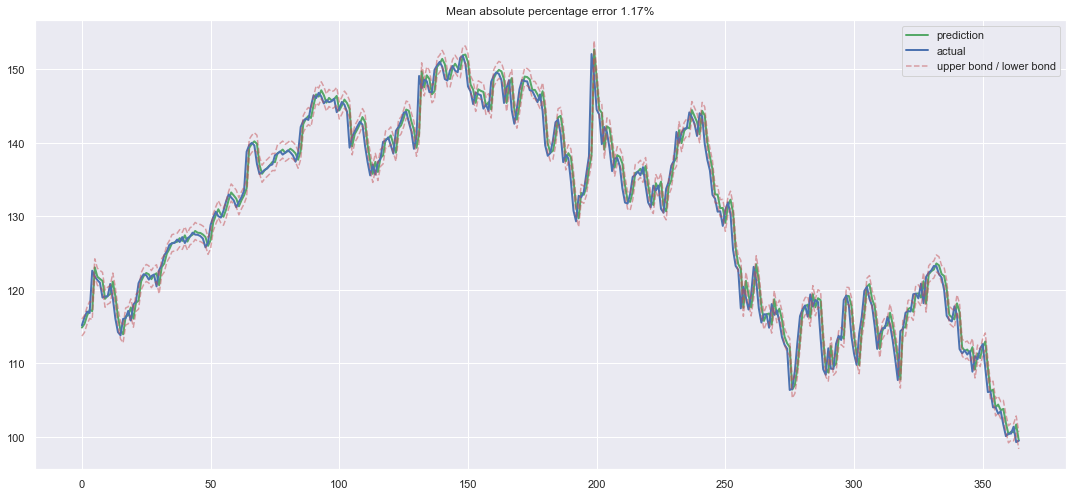

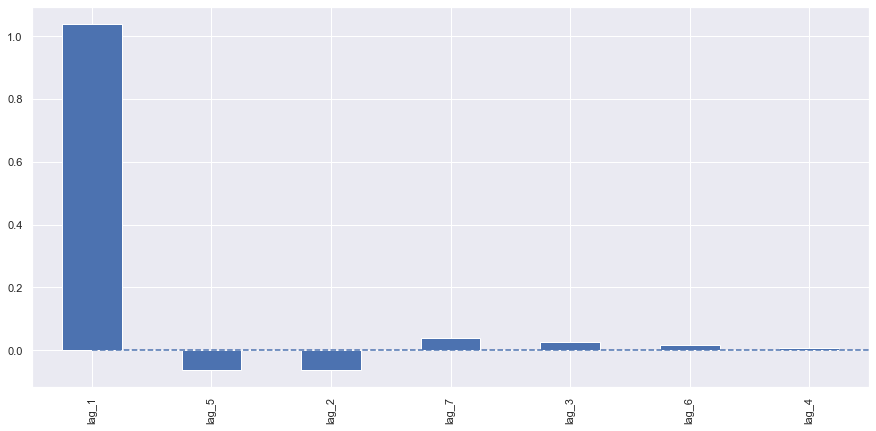

In [580]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

In [550]:
df["hour"] = df.index.hour
df["weekday"] = df.index.weekday
df['is_weekend'] = df.weekday.isin([5,6])*1
df.head()

,target,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,hour,weekday,is_weekend
Date,,,,,,,,,,
2017-01-03,39.481499,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0
2017-01-04,39.567001,39.481499,NaN,NaN,NaN,NaN,NaN,0,2,0
2017-01-05,39.723999,39.567001,39.481499,NaN,NaN,NaN,NaN,0,3,0
2017-01-06,40.395000,39.723999,39.567001,39.481499,NaN,NaN,NaN,0,4,0
2017-01-09,40.498299,40.395000,39.723999,39.567001,39.481499,NaN,NaN,0,0,0


In [551]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

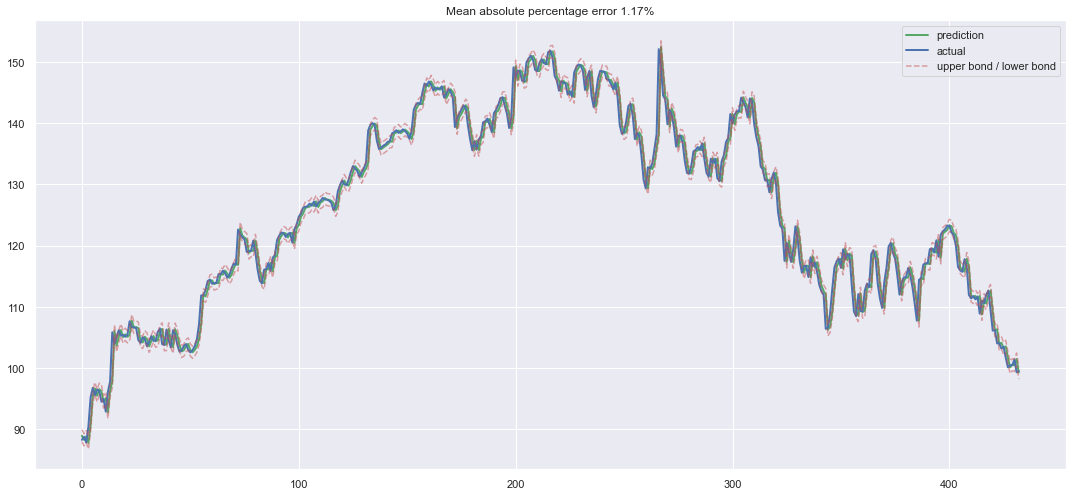

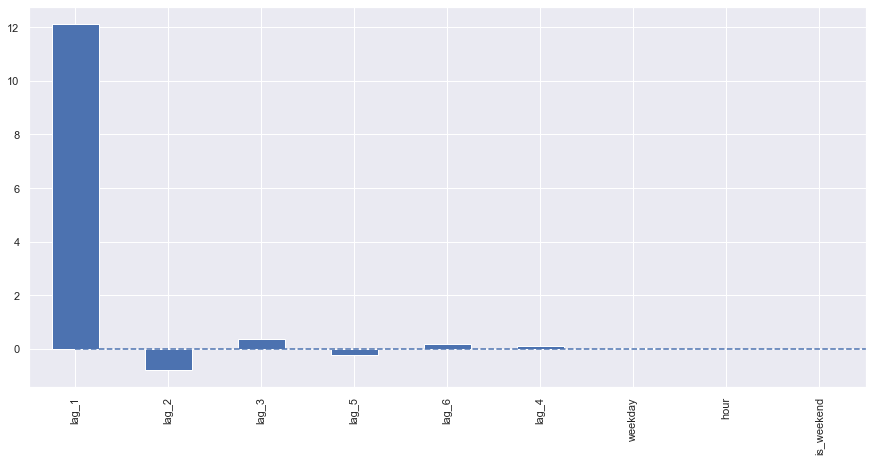

In [552]:
y = df.dropna().target
X = df.dropna().drop(['target'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

Как видно на графиках выше модель выдает очень даже неплохое качество, однако данный подход статистически бессмысленный.

Будем использовать для прогнозирования модель ARIMA, т.к. ряд нестационарный, в нем отсуствует сезонность и нет данных о внешних факторах для добавления в модель.

In [595]:
Ntest = 365
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

Проведем автоподбор параметров

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=12085.535, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.47 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.48 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3056.219, Time=0.68 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=3058.325, Time=1.22 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=3057.910, Time=0.81 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=9287.969, Time=1.32 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.72 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=3060.127, Time=1.16 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=3056.237, Time=1.76 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 8.664 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1082
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1525.1

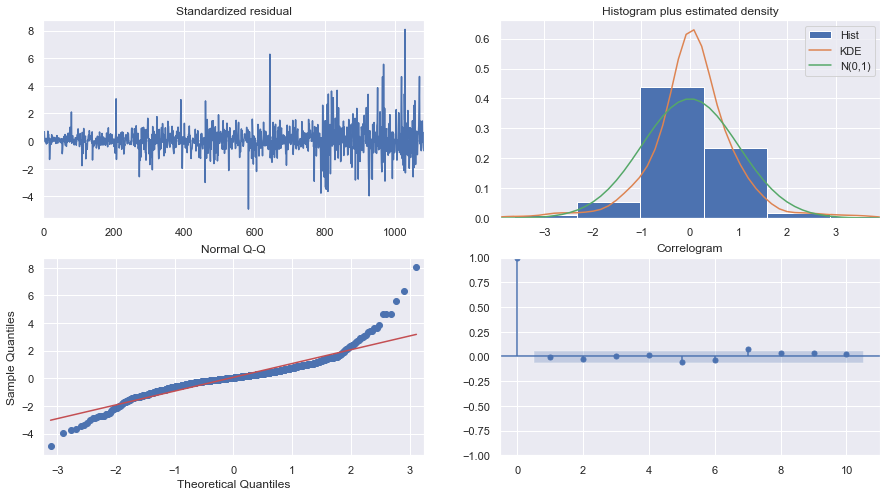

In [610]:
from pmdarima.arima import auto_arima

model_autoARIMA = auto_arima(df['target'].iloc[train_idx], start_p=0, start_q=0,
     test='adf',       # use adftest to find optimal 'd'
     max_p=7, max_q=3, # maximum p and q
     m=0,              # frequency of series
     d=0,           # let model determine 'd'
     seasonal=False,   # No Seasonality
     start_P=0, 
     D=0, 
     trace=True,
     error_action='ignore',  
     suppress_warnings=True, 
     stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [598]:
def plot_fit_and_forecast(result):
    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot(df['target'], label='data')
    train_pred = result.fittedvalues
    ax.plot(train.index, train_pred, color='green', label='fitted')

    prediction_result = result.get_forecast(Ntest)
    conf_int = prediction_result.conf_int()
    lower, upper = conf_int['lower target'], conf_int['upper target']
    forecast = prediction_result.predicted_mean
    error = mean_absolute_percentage_error(forecast, test.target.values)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    ax.plot(test.index, forecast, label='forecast')
    ax.fill_between(test.index, lower, upper, color='red', alpha=0.3)
    ax.legend()

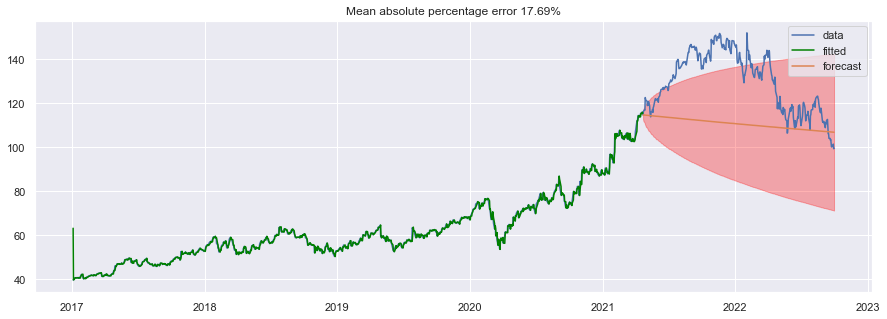

In [603]:
from statsmodels.tsa.arima.model import ARIMA

arima = ARIMA(train['target'], order=(1, 0, 1))
arima_result = arima.fit()

plot_fit_and_forecast(arima_result)

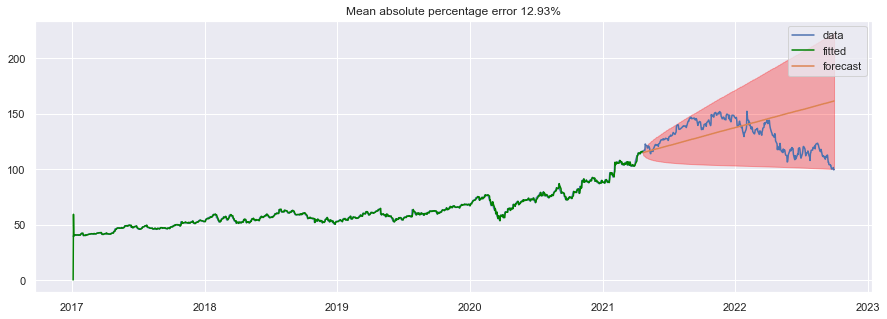

In [622]:
from statsmodels.tsa.arima.model import ARIMA

arima = ARIMA(train['target'], order=(1, 2, 5))
arima_result = arima.fit()

plot_fit_and_forecast(arima_result)

Процент ошибки модели по автоподобранным параметрам 17.96%
Процент ошибки модели с добавлением дифференцирования 2 порядка и скользящей средней 5 падает до 12.93% (подобрано вручную)

Проверим какое качество предсказания можно получить при использовании PROPHET

In [623]:
from prophet import Prophet

In [624]:
predictions = 365

df_prophet = df.target.reset_index()
df_prophet.columns = ['ds', 'y']
df_prophet.tail()

,ds,y
1442,2022-09-26,100.440002
1443,2022-09-27,100.459999
1444,2022-09-28,101.400002
1445,2022-09-29,99.300003
1446,2022-09-30,99.494003


In [625]:
train_df = df_prophet[:-predictions]

In [637]:
# declaring the model, it's necessary to pay attention to seasonality type we want to use
model = Prophet(weekly_seasonality=False, yearly_seasonality=False)
model.fit(train_df)

# creating one more specific dataset for predictions
# we also need to set data frequency here (by default - days)
future = model.make_future_dataframe(periods=predictions, freq='D')
future.tail()

20:45:25 - cmdstanpy - INFO - Chain [1] start processing
20:45:26 - cmdstanpy - INFO - Chain [1] done processing


,ds
1442,2022-04-17
1443,2022-04-18
1444,2022-04-19
1445,2022-04-20
1446,2022-04-21


In [638]:
forecast = model.predict(future)
forecast.shape

(1447, 13)

Mean absolute percentage error 15.78%


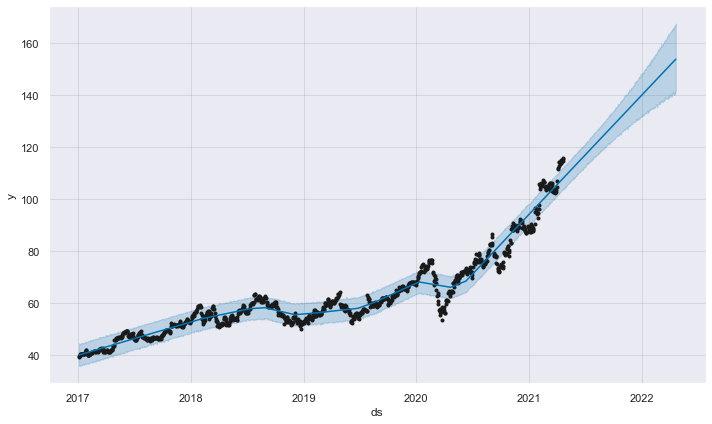

In [639]:
error = mean_absolute_percentage_error(df_prophet[-predictions:]['y'], forecast[-predictions:]['yhat'])
print("Mean absolute percentage error {0:.2f}%".format(error))
_ = model.plot(forecast)

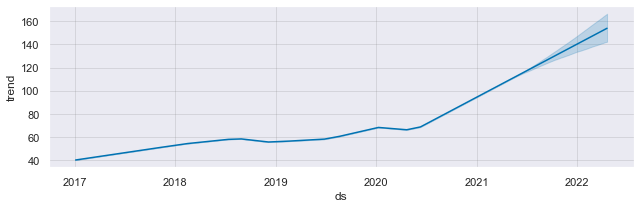

In [640]:
_ = model.plot_components(forecast)

Ошибка предсказания 15.78%, что выше чем у ARIMA с подобранными параметрами.

Попробуем добавить праздники в модель.

In [630]:
import holidays
holiday = pd.DataFrame([])
for date, name in sorted(holidays.UnitedStates(years=[2018,2019,2020]).items()):
    holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "US-Holidays"}, index=[0]), ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

holiday.head()

,ds,holiday
0,2018-01-01,US-Holidays
1,2018-01-15,US-Holidays
2,2018-02-19,US-Holidays
3,2018-05-28,US-Holidays
4,2018-07-04,US-Holidays


In [631]:
model_with_holidays = Prophet(holidays=holiday)
model_with_holidays.fit(train_df)

17:19:11 - cmdstanpy - INFO - Chain [1] start processing
17:19:12 - cmdstanpy - INFO - Chain [1] done processing


In [632]:
future = model_with_holidays.make_future_dataframe(periods=predictions, freq='D')
forecast = model_with_holidays.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
1440,2022-04-15,155.724596,131.624500,181.017964
1441,2022-04-16,156.525343,132.784773,180.151348
1442,2022-04-17,156.760687,132.583109,181.003690
1443,2022-04-18,156.271864,132.198451,181.209578
1444,2022-04-19,156.576157,131.797537,180.886719
1445,2022-04-20,156.854694,132.611960,182.186956
1446,2022-04-21,157.046735,132.166306,182.089979


Mean absolute percentage error 15.90%


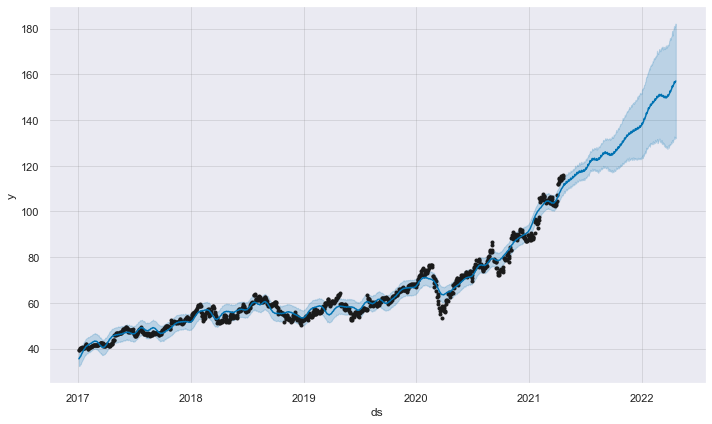

In [633]:
error = mean_absolute_percentage_error(df_prophet[-predictions:]['y'], forecast[-predictions:]['yhat'])
print("Mean absolute percentage error {0:.2f}%".format(error))
_ = model_with_holidays.plot(forecast)

Как видим качество модели стало даже хуже 15.90% ошибок.

По итогу всех экспериментов по качеству лидирует линейная регрессия.

Но если из адекватных моделей, то ARIMA с подобранными параметрами (1, 2, 5) и ошибкой в 12.93%. 
Для предсказания на год в целом считаю это неплохой результат для данных без явно выраженных паттернов.